---
title: "Portfolio Visualizer"
description: "Portfolio linear optimization"
date: "2025-07-15"
params:
  input_text:
    input: "text"
    label: "Enter text"
    value: "default"

---


# Part 1: 2 Asset Optimization


## Importing Library


In [75]:
# Import Library
import mercury as mr
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sciop
from datetime import datetime
import os

import plotly.graph_objs as go

In [77]:
# User Defined Stock Tickers 
assetlist = ["META","BA","GOOGL","TSM","AAPL","VOO"]

In [78]:
# Risk Free Rate
asset_risk_free = 0.02

## Data Prep and Extraction


In [79]:
# Get Stock Risk Return and Correlation

# Using YFinance to obtain stock close Price
stock_price = yf.download(tickers=assetlist,period = "10y", interval ="1mo")
# Find stock return
stock_return = stock_price["Close"].pct_change().dropna()

# Get mean and stdev of the stocks
monthly_mean_return = stock_return.mean()
monthly_stdev_return = np.std(stock_return,axis=0)

# Annualize 
mean_return = monthly_mean_return * 12
stdev_return = monthly_stdev_return * np.sqrt(12)

# Merge into a table
asset_risk_return_df = pd.DataFrame([mean_return, stdev_return],index=["Return", "Deviation"]).T 

#Find Sharpe Ratio
asset_risk_return_df["Sharpe"] = (
    asset_risk_return_df["Return"] - asset_risk_free
) / asset_risk_return_df["Deviation"]

# Get correlation between each stock
asset_correlation_matrix_df= stock_return.corr()


/var/folders/yj/_sykjyks31j7t9pdm3jfl0v00000gn/T/ipykernel_42270/1010211020.py:4: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  6 of 6 completed


# Part 2: N Asset Optimization


### GMV Portfolio


In [80]:
# Finding Weightage of Portfolio on Global Minimum Variance

# Step 1: Get Deviations with correct order
# Define order
asset_order = asset_risk_return_df.index
# Reindex correlation matrix rows and columns
asset_correlation_matrix_df = asset_correlation_matrix_df.loc[asset_order, asset_order]
# Get deviations
deviations = asset_risk_return_df["Deviation"].values

# Step 2: Get Covariance, Element Wise
cov_matrix = np.outer(deviations, deviations) * asset_correlation_matrix_df.values

# Step 3: Define Minimum Variance Function
def global_min_var_portfolio(weights):
    return weights.T @ cov_matrix @ weights # Matrix multiplication to find variance

# Step 4: Define Constraints and Bounds
number_of_assets = len(assetlist) # asset count
init_guess = np.ones(number_of_assets)/number_of_assets # start with equal weightages
bounds = [(0,1) for a in range(number_of_assets)] # Bound the Asset weightage
constraints = {'type': 'eq', # Equality Constraint
               'fun' : lambda w : np.sum(w)-1 # Must Equal to 0
               # This constraint ensures that sum of all weight = 1
               # or sum of weight - 1 = 0
               }

# Step 5: Solve for Efficient Portfolio
gmv_result = sciop.minimize(global_min_var_portfolio, init_guess, method='SLSQP',
                bounds=bounds, constraints=constraints)

# Step 6: Output Weightages
min_variance_weights = gmv_result.x
MVP_portfolio = dict(zip(asset_order, min_variance_weights))
print(f'''
      MVP Portfolio Generated:
      {MVP_portfolio}
      ''')


      MVP Portfolio Generated:
      {'AAPL': np.float64(0.0), 'BA': np.float64(0.0), 'GOOGL': np.float64(0.0), 'META': np.float64(0.0), 'TSM': np.float64(3.1414762460037715e-18), 'VOO': np.float64(1.0)}
      


## MVE Portfolio


In [81]:
# Finding Weightage for Mean Variance Efficient Portfolio

# Step 1: Extract Mean 
assets_mean = np.array([asset_risk_return_df["Return"][asset] for asset in assetlist])

# Step 2: Define Sharpe Formula
def negative_global_sharpe_portfolio(weights):
    mean_p = weights.T @ assets_mean
    variance = weights.T @ cov_matrix @ weights # Matrix multiplication to find variance
    return -(mean_p - asset_risk_free)/np.sqrt(variance)

# Step 3: Define Constraints and Bounds
number_of_assets = len(assetlist) # asset count
init_guess = np.ones(number_of_assets)/number_of_assets # start with equal weightages
bounds = [(0,1) for a in range(number_of_assets)] # Bound the Asset weightage
constraints = {'type': 'eq', # Equality Constraint
               'fun' : lambda w : np.sum(w)-1 # Must Equal to 0
               # This constraint ensures that sum of all weight = 1
               # or sum of weight - 1 = 0
               }

# Step 4: Solve for Efficient Frontier's Portfolio
mve_result = sciop.minimize(negative_global_sharpe_portfolio, init_guess, method='SLSQP',
                bounds=bounds, constraints=constraints)

# Step 5: Output Weightages
max_sharpe_weights = mve_result.x
MVE_portfolio = dict(zip(assetlist, max_sharpe_weights))
print(f'''
      MVE Portfolio Generated:
      {MVE_portfolio}
      ''')



      MVE Portfolio Generated:
      {'META': np.float64(0.4476031663307754), 'BA': np.float64(0.0), 'GOOGL': np.float64(0.15707096343729807), 'TSM': np.float64(0.30868859039873897), 'AAPL': np.float64(0.08663727983318768), 'VOO': np.float64(1.4799359654427136e-17)}
      


### Obtaining Mean, Stdev, Sharpe and Covariance Matrix of MVE and GMV Portfolio


In [82]:
# Find MVP's Mean, Stdev and Sharpe

# Mean
mvp_mean = min_variance_weights.T @ assets_mean
mve_mean = max_sharpe_weights.T @ assets_mean

# Variance
mvp_variance = min_variance_weights.T @ cov_matrix @ min_variance_weights 
mve_variance = max_sharpe_weights.T @ cov_matrix @ max_sharpe_weights

# Stdev
mvp_stdev = np.sqrt(mvp_variance)
mve_stdev = np.sqrt(mve_variance)

# Sharpe
mvp_sharpe = (mvp_mean-asset_risk_free )/ mvp_stdev
mve_sharpe = (mve_mean-asset_risk_free )/ mve_stdev

### Obtaining Covariance and Correlation of MVE and GMV Portfolio


In [83]:
# Find Covariance and Correlation
mvp_mve_cov = min_variance_weights.T @ cov_matrix @ max_sharpe_weights
mvp_mve_cor = mvp_mve_cov / (mvp_stdev * mve_stdev)

### Generating Combination of Assets


In [84]:
# Create a combination of weightages
w_mve = np.arange(0, 3, 0.02)
w_mvp = 1 - w_mve

# Create a range of return based on weightage
portfolio_return_list=[]
for index,row in enumerate(w_mve):
    mve_return= row * mve_mean
    mvp_return= w_mvp[index] * mvp_mean
    weighted_portfolio_return= mve_return + mvp_return
    portfolio_return_list.append(weighted_portfolio_return)

# Create variance for each weight
portfolio_variance_list=[]
for index, row in enumerate(w_mve):
    mve_var_indiv= (row)**2 * mve_variance
    mvp_var_indiv= (w_mvp[index])**2 * mvp_variance
    mvp_mve_var= 2*(row)*(w_mvp[index])*mvp_stdev*mve_stdev * mvp_mve_cor
    weighted_risk=mve_var_indiv + mvp_var_indiv + mvp_mve_var
    portfolio_variance_list.append(weighted_risk)

# Calculate Standard Deviation for each weight
portfolio_stdev_list=[]
for var in portfolio_variance_list:
    portfolio_stdev_list.append((np.sqrt(var)))

portfolio_sharpe_list=[]
for idx, mean in enumerate(portfolio_return_list):
    sharpe= (mean-asset_risk_free)/portfolio_stdev_list[idx]
    portfolio_sharpe_list.append(sharpe)

# Merge all data into df
efficient_frontier_matrix=pd.DataFrame({
    "w(MVE)":w_mve,
    "w(MVP)":w_mvp,
    "Mean Return":portfolio_return_list,
    "Variance":portfolio_variance_list,
    "Standard Deviation": portfolio_stdev_list,
    "Sharpe Ratio": portfolio_sharpe_list
})

# Add weightage dicts to efficient frontier matrix
weightage_list = []
for idx in range(len(efficient_frontier_matrix)):
    mve_w = efficient_frontier_matrix.iloc[idx]['w(MVE)']
    mvp_w = efficient_frontier_matrix.iloc[idx]['w(MVP)']

    combined_weights={}
    for asset in assetlist:  # assuming assetlist matches MVE/MVP keys
        mve_asset_weight = MVE_portfolio.get(asset, 0)
        mvp_asset_weight = MVP_portfolio.get(asset, 0)
        combined_weight = mve_w * mve_asset_weight + mvp_w * mvp_asset_weight
        combined_weights[asset] = round(combined_weight, 4)

    weightage_list.append(combined_weights)

efficient_frontier_matrix["Weightages"] = weightage_list

# Plotting


## Mean and Stdev of Each Asset


In [85]:
# Extract mean and stdev for each asset
asset_names = list(asset_risk_return_df["Return"].keys())
asset_means = [asset_risk_return_df["Return"][a] for a in asset_names]
asset_stdevs = [asset_risk_return_df["Deviation"][a] for a in asset_names]

In [86]:
# Sort portfolios by volatility for smooth line plotting
frontier_sorted_indices = np.argsort(portfolio_stdev_list)
frontier_sorted_vols = np.array(portfolio_stdev_list)[frontier_sorted_indices]
frontier_sorted_returns = np.array(portfolio_return_list)[frontier_sorted_indices]

# Sort the dataframe to match the frontier line order
efficient_frontier_matrix_sorted = efficient_frontier_matrix.iloc[frontier_sorted_indices].reset_index(drop=True)


# Convert dicts to formatted strings for hover
hover_weights = []
for w_dict in efficient_frontier_matrix_sorted["Weightages"]:
    hover_text = "<br>".join([f"{k}: {v:.2%}" for k, v in w_dict.items()])
    hover_weights.append(hover_text)
scatter_portfolios = go.Scatter(
    x=frontier_sorted_vols,
    y=frontier_sorted_returns,
    mode='lines',
    line=dict(color='blue', width=2),
    name="Portfolios",
    customdata=hover_weights,
    hovertemplate=
        "Volatility: %{x:.2f}<br>" +
        "Expected Return: %{y:.2f}<br><br>" +
        "<b>Weights:</b><br>%{customdata}<extra></extra>"
)

# 2. Max Sharpe portfolio (star marker)
max_sharpe = go.Scatter(
    x=[mve_stdev],
    y=[mve_mean],
    mode='markers',
    marker=dict(symbol='circle', size=10, color='red'),
    name='Max Sharpe Ratio'
)

# 3. Individual assets (if applicable)
individual_assets = go.Scatter(
    x=asset_stdevs,
    y=asset_means,
    mode='markers+text',
    text=assetlist,
    textposition='top center',
    marker=dict(symbol='circle', size=10, color='black'),
    name='Assets'
)

fig = go.Figure([scatter_portfolios,max_sharpe,individual_assets])
fig.update_layout(
    title="Efficient Fronter",
    xaxis_title = 'Volatility',
    yaxis_title = "Expected Returns",
    template= 'plotly_white'
)

In [87]:
# Format weights for display
ratios = [round(float(i * 100), 2) for i in max_sharpe_weights]

fig = go.Figure(data=[go.Pie(
    labels=assetlist,
    values=ratios,
    hole=0.5,  # creates the donut
    hoverinfo='label+percent',
    textinfo='label+percent',
    textposition='inside'
)])

fig.update_layout(
    title_text='MVE Portfolio Weightages (Donut Chart)',
    showlegend=True,
    template='plotly_white'
)

fig.show()

In [88]:
# Finding Capital Allocation Line

# Create weight range from 0 to 1 (inclusive) with 0.1 intervals
w_risky = np.round(np.arange(0, 1.05, 0.05), 3)
w_riskfree = np.round(1 - w_risky, 3)

# Create DataFrame with weight range
capital_allocation_weight = pd.DataFrame({
    "w1": w_risky,
    "w2": w_riskfree
})

# Create a range of return based on weightage
capital_allocation_return_list=[]
for index,row in capital_allocation_weight.iterrows():
    risky_return= row["w1"]*mve_mean
    riskfree_return= row["w2"]*asset_risk_free
    weighted_portfolio_return= risky_return+riskfree_return
    capital_allocation_return_list.append(weighted_portfolio_return)

# Calculate Variance for each weight
capital_allocation_variance_list=[]
for index, row in capital_allocation_weight.iterrows():
    total_volatility= (row["w1"])**2 *mve_stdev **2
    capital_allocation_variance_list.append(total_volatility)

# Calculate Standard Deviation for each weight
capital_allocation_stdev_list=[]
for var in capital_allocation_variance_list:
    capital_allocation_stdev_list.append((np.sqrt(var)))

# Calculate Sharpe Ratio for each weight
capital_allocation_sharpe_list=[]
for idx, weight in capital_allocation_weight.iterrows():
    capital_allocation_sharpe_list.append(mve_sharpe)

# Merge all data into df
capital_allocation_matrix=pd.DataFrame({
    "w(MVE)":w_risky,
    "w(Risk Free)":w_riskfree,
    "Mean Return":capital_allocation_return_list,
    "Variance":capital_allocation_variance_list,
    "Standard Deviation": capital_allocation_stdev_list,
    "Sharpe Ratio": capital_allocation_sharpe_list
})

Text(0.5, 1.0, 'Capital Allocation Line')

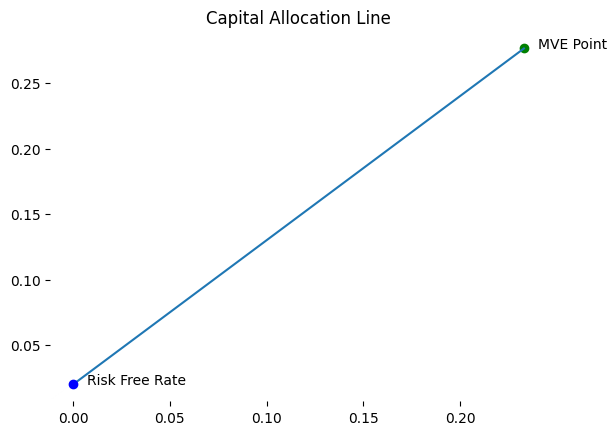

In [66]:
# Plotting CAL Line
fig,ax= plt.subplots()
#Plotting MVE Point
ax.plot(mve_stdev,mve_mean,"go")
plt.annotate(text=f"MVE Point",
             xy=(mve_stdev,mve_mean),
             textcoords="offset points",
             xytext=(10,0),
             ha="left")

#Plotting CAL Line
ax.plot(capital_allocation_stdev_list,capital_allocation_return_list,label="Capital Allocation Line")

# Annotating the Risk Free Rate
ax.plot(0,asset_risk_free,"bo")
plt.annotate(text=f"Risk Free Rate",
             xy=(0,asset_risk_free),
             textcoords="offset points",
             xytext=(10,0),
             ha="left")

# Plotting Capital Allocation line

# Formatting the Graph
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title(label="Capital Allocation Line")

In [95]:
import plotly.graph_objects as go
import numpy as np

# Assuming asset_correlation_matrix is a pandas DataFrame
fig = go.Figure(data=go.Heatmap(
    z=asset_correlation_matrix_df.values,
    x=asset_correlation_matrix_df.columns,
    y=asset_correlation_matrix_df.index,
    colorscale='RdBu',       # Red-Blue diverging colormap
    zmin=-1,
    zmax=1,
    colorbar=dict(title='Correlation'),
    hoverongaps=False
))

fig.update_layout(
    title="Asset Correlation Matrix",
    xaxis_title="Assets",
    yaxis_title="Assets",
    template="plotly_white"
)

fig.show()

#add number
#reverse order

In [93]:
summary_data = asset_risk_return_df.copy()
summary_data = summary_data.reset_index().rename(columns={'index': 'Asset'})

# Append MVE and MVP data as separate rows
summary_data = pd.concat([
    summary_data,
    pd.DataFrame([
        {
            "Ticker": "MVE",
            "Return": mve_mean,
            "Deviation": mve_stdev,
            "Sharpe": mve_sharpe
        },
        {
            "Ticker": "MVP",
            "Return": mvp_mean,
            "Deviation": mvp_stdev,
            "Sharpe": mvp_sharpe
        }
    ])
], ignore_index=True)


In [94]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>Ticker</b>", "<b>Return</b>", "<b>Deviation</b>", "<b>Sharpe Ratio</b>"],
        fill_color='lightblue',
        align='center'
    ),
    cells=dict(
        values=[
            summary_data["Ticker"],
            summary_data["Return"].round(4),
            summary_data["Deviation"].round(4),
            summary_data["Sharpe"].round(4)
        ],
        fill_color='white',
        align='center'
    )
)])

fig.update_layout(title="Risk-Return Summary Table with Sharpe Ratios")
fig.show()
